In [1]:
import pickle
import torch
import numpy as np
import scipy
import os
import seaborn as sns
sns.set_context("talk")
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
from cca_core import get_cca_similarity
from utils import *


mode_to_default = {"beta": 0.0, "dropout": 0, "size": 150}
mode_to_label = {"beta": r"$\beta$", "dropout": "dropout", "size": "dim"}
modes = [("beta", [0.0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0], 0.25),
         ("dropout", [0.0, 0.1, 0.25, 0.5, 0.65, 0.75, 0.85, 0.9], 0.5),
         ("size", [150, 125, 100, 75, 50, 25, 10, 5], 25)]

## 1. Visualise regular model performance

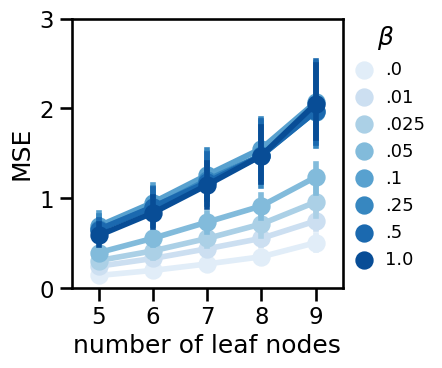

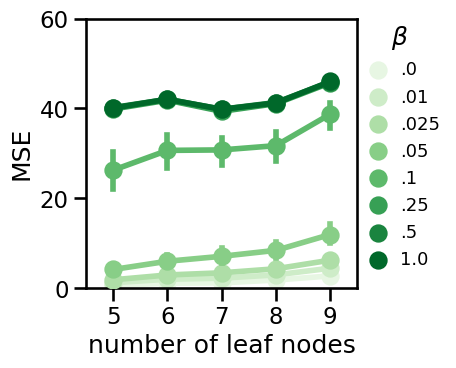

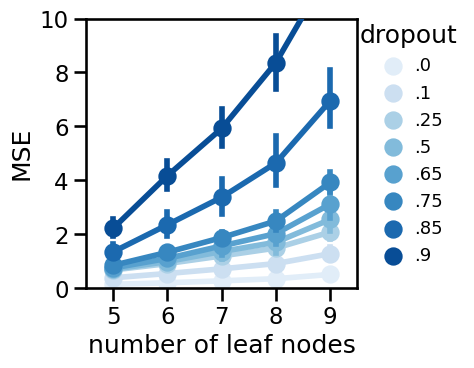

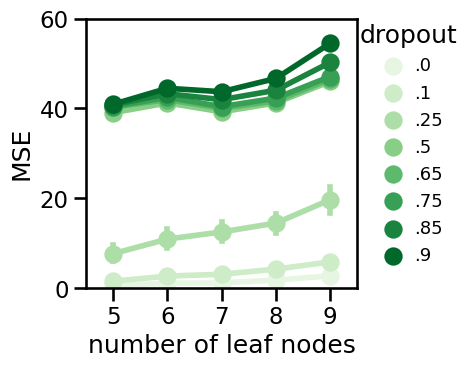

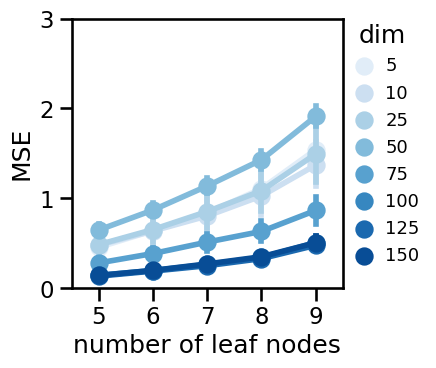

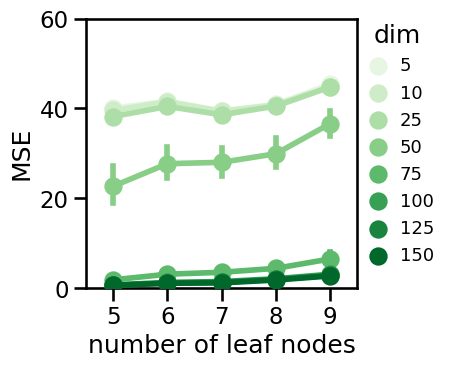

In [2]:
for mode, weights, best in modes:
    for sample_type in ["regular", "exceptions"]:
        x, y, hue = [], [], []
        for w in weights:
            for seed in range(1, 11):
                model = f"treelstm_bottleneck_seed={seed}"
                snts, prds, old_labels, new_labels = \
                    load(model, f"test_{mode}={w}")

                # Store the average MSE per length
                results = defaultdict(list)
                for s, p, o, n in zip(snts, prds, old_labels, new_labels):
                    length = len(s.replace('+', '').replace('-', '').replace('(', '').replace(')', '').split())
                    if (sample_type == "regular" and o == n) or (sample_type == "exceptions" and o != n):
                        results[length].append((n - p)**2)
                x.extend(list(results.keys()))
                y.extend([np.mean(x) for x in results.values()])
                hue.extend([w] * len(results))

        # Visualise lengths x MSE for regular and exceptional examples
        plt.figure(figsize=(3.5, 3.5))
        ax = sns.pointplot(
            x=x, y=y, palette="Blues" if sample_type == "regular" else "Greens", hue=hue)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(
            handles, [str(l).replace('0.', '.') for l in labels],
            bbox_to_anchor=(0.95, 1.04), title=mode_to_label[mode], fontsize=13, frameon=False,
            handletextpad=0.2)
        plt.ylim(0, (10 if mode == "dropout" else 3) if sample_type == "regular" else 60)
        plt.xlabel("number of leaf nodes")
        plt.ylabel("MSE")
        plt.savefig(f"figures/performance_{sample_type}_{mode}.pdf", bbox_inches="tight")
        plt.show()

## 2. Visualise the ranking

In [ ]:
with open("../../data/arithmetic_ambiguous/test.src") as f_src,\
    open("../../data/arithmetic_ambiguous/test.tgt") as f_tgt:
    labels = [eval(s.strip()) != int(t.strip())
              for i, (s, t) in enumerate(zip(f_src, f_tgt))]

In [ ]:
for cca in [False, True]:
    for mode, weights, best in modes:
        plt.figure(figsize=(5, 5))
        sentences, distances = get_distances(
            weights=weights[1:],
            dataset="test",
            mode=mode,
            apply_cca=cca)

        ranking = np.argsort(distances[best])
        x = list(range(len(ranking)))
        hue = ["exceptions" if labels[i] else "regular" for i in ranking]

        ax = sns.histplot(
            x=x, hue=hue, element="step", fill=False, bins=20,
            palette=[sns.color_palette("Blues", 4)[-1],
                     sns.color_palette("Greens", 4)[-1]])

        plt.xlabel("position in ranking")
        plt.ylabel("#samples")
        ax.legend(
            handles=ax.legend_.legendHandles,
            labels=[t.get_text() for t in ax.legend_.texts],
            frameon=False)
        plt.savefig(f"figures/ranking_{mode}_cca={cca}.pdf", bbox_inches="tight")
        plt.show()

## 3. Summarise the different rankings in a bar plot

In [ ]:
x, y, hue = [], [], []
k = 0
for cca in [True, False]:
    for mode, weights, best in modes:
        if mode == "beta" and cca:
            best = 0.25
        sentences, similarities = get_distances(
            weights=[best],
            dataset="test",
            mode=mode,
            apply_cca=cca)
        ranking = np.argsort(similarities[best]).tolist()
        ranking = [ranking.index(i)/25000 for i in range(len(ranking))]

        for s, i in zip(sentences, range(len(labels))):
            x.append(k)
            y.append(ranking[i])
            hue.append("regular" if not labels[i] else "exceptions")
        k += 1

plt.figure(figsize=(5, 5))
ax = sns.boxplot(x=x, y=y, hue=hue, palette=
                     {"exceptions": sns.color_palette("Greens", 5)[3],
                      "regular": sns.color_palette("Blues", 5)[3]},
                     fliersize=0)
plt.legend([], [], frameon=False)
plt.ylabel("relative position")
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(["PP, DVIB", "PP, dropout", "PP, dim.",
                    "TT, DVIB", "TT, dropout", "TT, dim."], rotation=45)
plt.xlabel(r"bottleneck")
plt.ylim(-0.02, 1.02)
plt.savefig("figures/relative_positions.pdf", bbox_inches="tight")
plt.show()

## 4. Visualise the training dynamics using the compositional & non-compositional targets

In [ ]:
from tensorflow.python.summary.summary_iterator import summary_iterator

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


modes = [("beta", [0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]),
         ("dropout", [0, 0.1, 0.25, 0.5, 0.65, 0.75, 0.85, 0.9]),
         ("size", [150, 125, 100, 75, 50, 25,  10, 5])]

for EVALUATION in ["comp", "noncomp"]:
    for setup, weights in modes:
        if EVALUATION == "noncomp":
            colors = sns.color_palette("Greens", 10)
            affix = ""
        else:
            colors = sns.color_palette("Blues", 10)
            affix = "_comp"

        plt.figure(figsize=(3.3, 3.3))
        for weight in weights:
            epochs = []
            mses = []
            comp_mses = []

            for seed in [1, 2, 3, 4, 5, 6, 7, 8, 10]:
                comp_mses_ = []
                mses_ = []

                prefix = "../../tree_lstms/runs/arithmetic/treelstm_bottleneck"
                if weight == 0.0 or weight == 150:
                    fn = f"{prefix}=dvib_beta=0_size=150_dropout=0_seed={seed}/"
                elif setup == "beta":
                    fn = f"{prefix}=dvib_beta={weight}_size=150_dropout=0_seed={seed}/"
                elif setup == "dropout":
                    fn = f"{prefix}=dropout_beta=0_size=150_dropout={weight}_seed={seed}/"
                else:
                    fn = f"{prefix}=size_beta=0_size={weight}_dropout=0_seed={seed}/"

                fn = fn + os.listdir(fn)[0]
                epoch = 1
                for e in summary_iterator(fn):
                    for v in e.summary.value:
                        if v.tag == f'MSE{affix}/dev':
                            epochs.append(epoch)
                            mses_.append(v.simple_value)
                            epoch += 1
                        if v.tag == f"MSE{affix}/dev":
                            comp_mses_.append(v.simple_value)
                comp_mses_ = comp_mses_[:2] + moving_average(comp_mses_, 5).tolist() + comp_mses_[-2:]
                comp_mses.extend(comp_mses_)
                mses_ = mses_[:2] + moving_average(mses_, 5).tolist() + mses_[-2:]
                mses.extend(mses_)
            ax = sns.lineplot(x=epochs, y=comp_mses, label=weight, color=colors.pop(0))
        plt.ylim(0, 10)
        plt.xlim(4, 50)
        plt.xlabel("epochs")
        plt.ylabel("MSE")
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(
            handles, [str(l).replace('0.', '.') for l in labels],
            bbox_to_anchor=(.98, 1.04), title=setup.replace("beta", r"$\beta$").replace("size", "dim"),
            handletextpad=0.2, fontsize=13, frameon=False)
        plt.savefig(f"figures/training_dynamics_mse_{EVALUATION}_{setup}.pdf", bbox_inches="tight")
        plt.show()